In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from create_df_for_non_ipynb import create_dataframe
from path_util import data_path
from count_contributions import contributions_by_user, amount_detailed, avg_unique_auth_page_lengths
from visualizations import viz_scatterplot_correlation, viz_sideways, relative_positive_negative, viz_gender_target
from sum_stats import sum_up_attributes

In [2]:
db_path = data_path / "data_bases" / "all_occupations.db"
con = sqlite3.connect(db_path)

df_all = pd.read_sql('SELECT occ_code, occ_group, occ_title, lenient_links, lenient_revs, lenient_lengths, women, white, african_american, asian, hispanic  FROM occupations', con)
df = df_all # make a copy

df = df.loc[df['women'] != "null"] # delete nulls

# fix parsing as float and rounding
for col in ["women", "white", "african_american", "asian", "hispanic"]:
    df[col] = df[col].astype(float)
    df[col] = df[col].apply(lambda x: round(x, 3))

# add a column for non-hispanic white people
if "non_hispanic_white" not in df:
    df.insert(8, "non_hispanic_white", df["white"].subtract(df["hispanic"]))

# Naive assumption that 1-women == men
if "men" not in df:
    df.insert(6, "men", (df["women"] - 1).abs())
    
df_detailed = df # make copy
df_detailed = df_detailed.loc[df['occ_group'] == "detailed"] # has 453 rows (out of 831; so approx 55% of all detailed occs)

df_detailed = df_detailed.dropna() # after removing NaNs has 285 rows (so approx. 34.3% of all detailed)
df_detailed.head() 

,occ_code,occ_group,occ_title,lenient_links,lenient_revs,lenient_lengths,men,women,white,non_hispanic_white,african_american,asian,hispanic
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...","{""Chief executive officer"": [{""revid"": 6437689...","{""Chief executive officer"": 17489}",0.709,0.291,0.857,0.783,0.059,0.068,0.074
5,11-1021,detailed,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...","{""General manager"": [{""revid"": 749862417, ""use...","{""General manager"": 7116, ""Operations manageme...",0.636,0.364,0.827,0.724,0.093,0.046,0.103
10,11-2011,detailed,Advertising and Promotions Managers,[],{},{},0.576,0.424,0.787,0.725,0.121,0.052,0.062
12,11-2021,detailed,Marketing Managers,"[[""Marketing management"", ""http://en.wikipedia...","{""Marketing management"": [{""revid"": 837236871,...","{""Marketing management"": 16750, ""Chief marketi...",0.386,0.614,0.835,0.752,0.062,0.073,0.083
13,11-2022,detailed,Sales Managers,[],{},{},0.694,0.306,0.864,0.758,0.059,0.050,0.106


In [3]:
articles_per_detailed = amount_detailed(df_all, df_detailed)
unique_auths, page_lengths, number_articles = avg_unique_auth_page_lengths(df_detailed)

if "art_per_detailed" not in df_detailed:
    df_detailed.insert(4, "art_per_detailed", articles_per_detailed)

if "avg_unique_auths" not in df_detailed:
    df_detailed.insert(6, "avg_unique_auths", unique_auths)
    
if "avg_art_lengths" not in df_detailed:
    df_detailed.insert(8, "avg_art_lengths", page_lengths)
    
if "amount_art" not in df_detailed:
    df_detailed.insert(4, "amount_art", number_articles)
    
df_detailed.head(3)

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,men,women,white,non_hispanic_white,african_american,asian,hispanic
3,11-1011,detailed,Chief Executives,"[[""Chief executive officer"", ""http://en.wikipe...",1,0.026316,"{""Chief executive officer"": [{""revid"": 6437689...",1756.0,"{""Chief executive officer"": 17489}",17489.0,0.709,0.291,0.857,0.783,0.059,0.068,0.074
5,11-1021,detailed,General and Operations Managers,"[[""General manager"", ""http://en.wikipedia.org/...",2,0.052632,"{""General manager"": [{""revid"": 749862417, ""use...",412.5,"{""General manager"": 7116, ""Operations manageme...",38205.5,0.636,0.364,0.827,0.724,0.093,0.046,0.103
10,11-2011,detailed,Advertising and Promotions Managers,[],0,0.000000,{},0.0,{},0.0,0.576,0.424,0.787,0.725,0.121,0.052,0.062


In [4]:
df_detailed.columns

Index(['occ_code', 'occ_group', 'occ_title', 'lenient_links', 'amount_art',
       'art_per_detailed', 'lenient_revs', 'avg_unique_auths',
       'lenient_lengths', 'avg_art_lengths', 'men', 'women', 'white',
       'non_hispanic_white', 'african_american', 'asian', 'hispanic'],
      dtype='object')

Pearsons correlation: 0.180
The p-value is 0.0023380492935217607


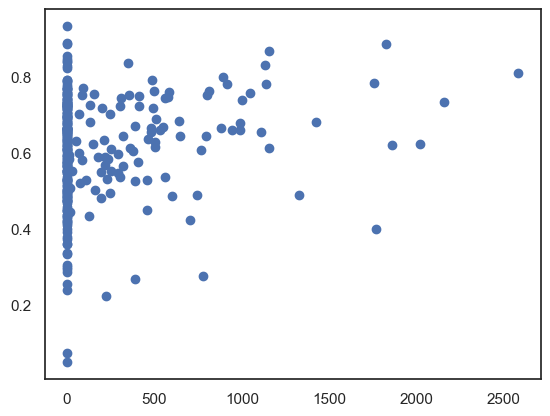

In [9]:
target_var = "non_hispanic_white"

second_var = "avg_unique_auths"

viz_scatterplot_correlation(df_detailed, target_var, second_var)

<AxesSubplot:>

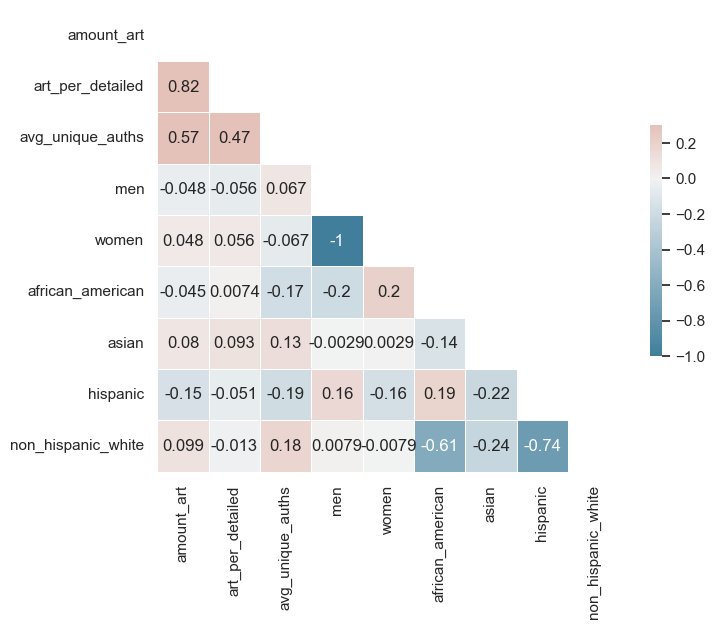

In [6]:
sns.set_theme(style="white")

corr_df = df_detailed[["amount_art", "art_per_detailed", "avg_unique_auths", "men", "women", "african_american", 
                       "asian", "hispanic", "non_hispanic_white"]].apply(pd.to_numeric)
corr_df.dropna(inplace = True)
corr = corr_df.corr(min_periods = 0)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})